In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import sys

In [2]:
sys.path.append('.')
sys.path.append('../src')
from models import model
from dataset import data
from cosine_sim import pd_embeddings

In [3]:
path4 = os.path.abspath('../') # указывает предыдущий каталог каталога, в котором находится текущий файл
device = 'cpu'
filepath = path4 + '\output\\resnet.pth'
resnet = model('resnet')
resnet.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))
train_loader, val_loader, test_loader = data('resnet')
train_dataset_emb, test_dataset_emb = pd_embeddings(resnet, train_loader, test_loader)

In [4]:
# cosine similarity function
def get_cos_sim(x, y=None, index=None, columns=None):
    similarity = cosine_similarity(x, y)
    return pd.DataFrame(similarity, index=index, columns=columns)

In [5]:
# getting data of 10th label (just example - practically any label of 500 can be chosen)
emb_10_test = test_dataset_emb[test_dataset_emb['label'] == 10].reset_index(drop=True)
emb_10_train = train_dataset_emb[train_dataset_emb['label'] == 10].reset_index(drop=True)
one_example = cosine_similarity(emb_10_train.iloc[5]['images_train'], emb_10_test.iloc[0]['images_test'])
print('This is a cosine similarity for one example: ', one_example[0][0])

This is a cosine similarity for one example:  0.79993963


In [6]:
# getting cosine similarity for class #c: taking 2 pictures (one from training set, one from test set)
def cos_data(c):
    # getting data of #c label (any label of 500 can be chosen)
    emb_test = test_dataset_emb[test_dataset_emb['label'] == c].reset_index(drop=True)
    emb_train = train_dataset_emb[train_dataset_emb['label'] == c].reset_index(drop=True)
    a = emb_train['images_train'].values
    b = emb_test['images_test'].values
    a = np.array(a.tolist()).reshape(18, 512)
    b = np.array(b.tolist()).reshape(3, 512)
    return get_cos_sim(a, b)

Text(69.0, 0.5, 'Train embeddings 10 label')

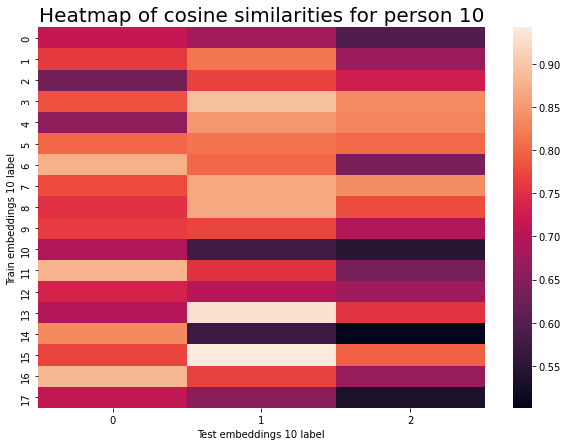

In [7]:
k = 10
plt.figure(figsize=(10, 7))
plt.title(f'Heatmap of cosine similarities for person {k}', fontsize=20)  # title with fontsize 20
sns.heatmap(cos_data(k))
plt.xlabel(f'Test embeddings {k} label')  # x-axis label
plt.ylabel(f'Train embeddings {k} label')  # y-axis label

In [8]:
def diff_classes(x, y):
    emb_x_test = test_dataset_emb[test_dataset_emb['label'] == x].reset_index(drop=True)
    c = emb_x_test['images_test'].values
    c = np.array(c.tolist()).reshape(len(c), 512)
    emb_y_test = test_dataset_emb[test_dataset_emb['label'] == y].reset_index(drop=True)
    d = emb_y_test['images_test'].values
    d = np.array(d.tolist()).reshape(len(d), 512)
    return get_cos_sim(c, d)

Text(69.0, 0.5, 'Test embeddings 10 label')

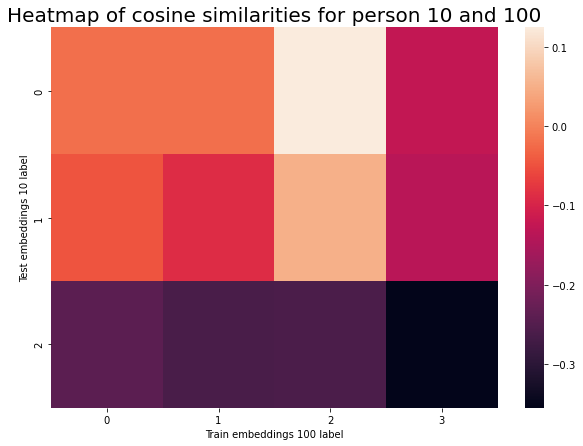

In [9]:
plt.figure(figsize=(10, 7))
x, y = 10, 100
plt.title(f'Heatmap of cosine similarities for person {x} and {y}', fontsize=20)  # title with fontsize 20
sns.heatmap(diff_classes(x, y))
plt.xlabel(f'Train embeddings {y} label')  # x-axis label
plt.ylabel(f'Test embeddings {x} label')  # y-axis label

In [10]:
stats_train = train_dataset_emb.groupby('label').agg(np.mean)  # getting mean embedding
stats_test = test_dataset_emb.groupby('label').agg(np.mean)  # for each label | class
# So we computed the mean embedding for each class/label. But some classes are presented only
# in train or test datasets. So we need to create a merged DataFrame to compute cosine similarity.
merged = pd.merge(stats_train, stats_test, on="label")
merged = merged.reset_index()
classes = len(merged['images_train'].values)  # to know how many rows / classes
# we have in the merged df
t_rain = merged['images_train'].values
t_est = merged['images_test'].values
t_rain = np.array(t_rain.tolist()).reshape(classes, 512)
t_est = np.array(t_est.tolist()).reshape(classes, 512)
wow = get_cos_sim(t_rain, t_est, index=merged['label'].values,
                  columns=merged['label'].values)

<AxesSubplot:>

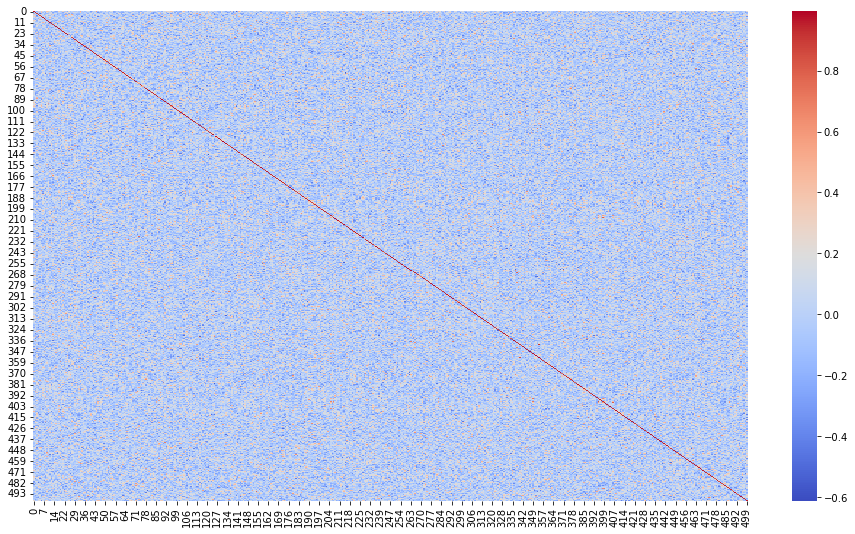

In [11]:
plt.figure(figsize=(16, 9))
sns.heatmap(wow, cmap="coolwarm")

In [12]:
print('We see that embeddings of the same classes/labels are close in train and test datasets (red line), '
      'while embeddings of different classes are relatively far (blue area).')

We see that embeddings of the same classes/labels are close in train and test datasets (red line), while embeddings of different classes are relatively far (blue area).
